# Full MARS demo

This is the tutorial from the readme of MARS_Developer in Jupyter notebook form.

## 1. 📁 Create a new MARS Training Project

Your MARS project directory will contain all the files created during the process of training MARS detector and pose models on your data.

In addition to creating a project directory, `create_new_project` takes two optional arguments:
* Set `download_MARS_checkpoints=True` to download pre-trained MARS detection and pose models. If your dataset looks similar to MARS, initializing training from the pre-trained models should help decrease your training data requirements. <font color=red>TODO: finish unploading these</font>
* Set `download_demo_data=True` to download a sample dataset, consisting of 2000 frames from videos in the [CRIM13 dataset](https://data.caltech.edu/records/1892), with accompanying manual annotations of animal pose collected via Amazon SageMaker. The sample dataset can also be previewed [here](https://drive.google.com/drive/u/0/folders/1J73k-RC1CyJQOjUdWr-75P3w_mfpRvXr).

In [1]:
from create_new_project import *

location = 'D:/'
name = 'my_project'

create_new_project(location, name,
                   download_MARS_checkpoints=True,
                   download_demo_data=True)

TypeError: create_new_project() got an unexpected keyword argument 'download_demo_data'

Within your project folder is a file called `project_config.yaml`. This file contains many important features: keypoint and animal names, instructions for your annotation job, and names/data assignments for detection and pose models. Open this file in a text editor and fill in the fields as instructed in the comments.

## 2. ✍️ Collect a set of manually annotated animal poses
In this step, we will get some training data for our detector and pose estimator.

> If you set `download_demo_data=True` in step 1, **skip to step 2.3** to format your data for training.

> If you've already annotated some poses in DeepLabCut, copy the annotation csv to `my_project/annotation_data`, and the images you annotated to `my_project/annotation_data/raw_images`. Set `manifest_name` in `project_config.yaml` to the name of your csv.
>
> Then **skip to step 2.3** to format your data for training.

### 2.1 Extract video frames that you would like to annotate
First, we need to collect a set of video frames to annotate. The script `extract_frames.py` will sample frames from all videos found in a directory, and save those frames as jpg files.

If you've already extracted frames, copy them to `my_project/annotation_data/raw_images` so they can be accessed during model training.

<font color=red>TODO: wrap and test extract_raw_frames.py, and add the neuroethology Util repository to MARS_Developer</font>

In [ ]:
# python extract_raw_frames.py input_dir /path/to/videodir project /path/to/savedir/my_project n_frames 500

You should now have a folder `my_project/annotation_data/raw_images` of video frames.

### 2.2 Run a labeling job
Refer to [these instructions](https://github.com/neuroethology/MARS_Developer/blob/develop/pose_annotation_tools/docs/readme_groundTruthSetup.md) to run a labeling job on Amazon SageMaker.

This job will produce a file called `output.manifest` which you should add to `my_project/annotation_data`. If you change the name of this manifest file, be sure to update the `manifest_name` field of `my_project/project_config.yaml` appropriately.

### 2.3 Post-process the manual pose annotations
This script carries out several steps to create "ground truth" keypoint locations by taking the median across AWS workers, correct for left/right flips of body part labels, and package your data for model-training. The processed annotation data will be added as a new file to `annotation_data`.

In [ ]:
from pose_annotation_tools.annotation_postprocessing import *

project_path = 'D:\my_project'
annotation_postprocessing(project_path)

### 2.4 Visualize some manual pose annotations

We'll next take a look at the inter-annotator variability in your pose labels, as this is a good predictor for how well MARS will perform. (If you annotated pose yourself you can skip this step.)

To look at annotations on an example frame, call `plot_frame`. It takes as input a project path and a number (specifying the image in your annotation dataset.) It also takes two optional plotting arguments:
* `markersize` the size of the keypoint makers (default is 8)
* `figsize` the width and height of the plot (default is [15,20])

The colored points are the raw annotation data. Points are colored by body part, and all points of a given marker shape come from the same worker.

The black and white points are the medians across annotators. These medians are the "ground truth" that we'll use to train MARS.

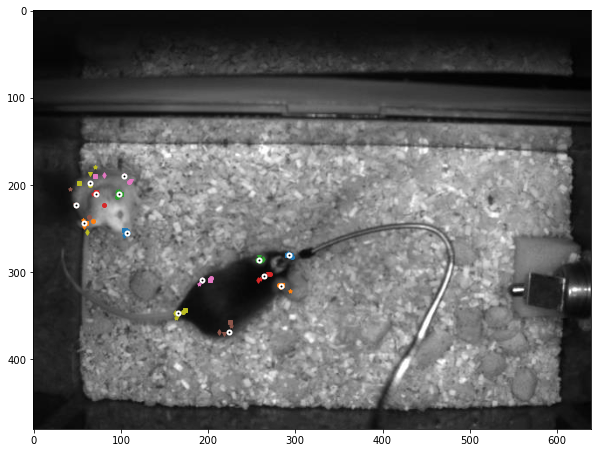

In [6]:
from pose_annotation_tools.annotation_postprocessing import *

project_path = 'D:\my_project'
frame_num = 42  # the frame number to look at in your data

plot_frame(project_path,frame_num, markersize=4, figsize=[10,14])

To summarize worker performance, we'll look at the **Percent Correct Keypoints (PCK)**. This is the percentage of keypoints from individual workers that fall within a radius X of the "ground truth" worker median.

For each keypoint, we compute the distance from each worker's annotation to the median of the other four, on each frame. We then plot cdfs of **median** (solid line) and **mean** (dashed line) worker-to-median distances for each frame, as well as a shaded area whose upper and lower bounds are the min and max worker-to-median distances, respectively.

`plot_summary` summarizes worker performance for your dataset. It takes four optional arguments:
* `animal_names` specifies which animals to generates plots for (defaults to all.)
* `xlim` is a two-element list specifying the min and max bounds of the x axis for all subplots.
* `pixel_units=True` plots in units of pixels instead of cm.
* `combine_animals=True` pools data across animal types in your dataset.

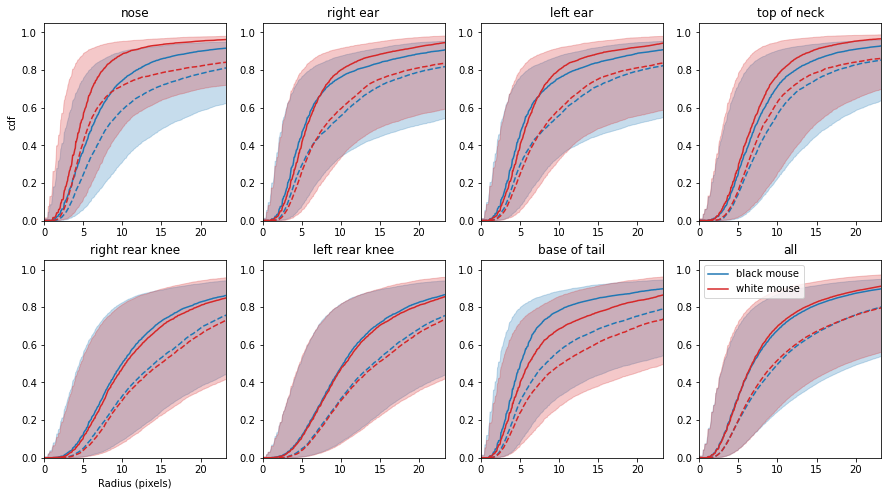

In [1]:
from pose_annotation_tools.annotation_postprocessing import *

project_path = 'D:\my_project'
plot_summary(project_path, combine_animals=False)

## 3. 🎯 Fine-tune the MARS detector to your data

<font color=red>TODO: set NUM_TRAIN_EXAMPLES in the train_config file programmatically! This affects learning rate scheduling, so we should get it right.

Also TODO: clear out some of these warning messages.</font>

### 3.1 Run the training code
`run_training` takes two optional arguments:
* `models` takes names of detectors to train, in case you only want to work on one detector at a time (MARS trains all detectors sequentially by default.)
* `max_training_steps` overrides `NUM_TRAIN_ITERATIONS` in `train_config.yaml` (300,000 by default). You can set this to a small number to confirm everything is working before launching your full training job.

If training is interrupted, it will resume from the most recent model checkpoint; MARS saves checkpoints every 30 minutes (adjust this in `my_project/detection/train_config.yaml`), and when training completes.

In [ ]:
from multibox_detection import train

project_path = 'D:\my_project'
train.run_training(project_path, max_training_steps=15)

### 3.2 Visualize model performance and pick the best checkpoint

During training, we saved a model checkpoint every 30 minutes (by default). We'll visualize the performance of our saved checkpoints on a held-out validation set of images to determine whether performance has plateaued, and use this to pick our best-performing version of the model.

<font color=red>TODO: add early stopping code here?</font>

After picking the checkpoint that performs best on your validation set, we can create some additional performance figures on the test set:

In [ ]:
# add code to generate PR curve figure here


### 3.3 (Optional) test your detector on new videos

💡 If you are working with top-view mouse videos, it is possible that MARS's pose estimator will work for you out of the box now that you have a working detector. Skip to step 5 to try it out! If you're not happy with the performance, continue to step 4 where you'll be able to fine-tune the pose estimator.

## 4. 🐁 Fine-tune the MARS pose estimator to your data


### 4.1 Run the training code
Training the pose estimator is the same as training your detectors.

`run_training` again takes two optional arguments:
* `models` takes names of pose models to train, in case you only want to work on one model at a time (MARS trains all detectors sequentially by default.)
* `max_training_steps` overrides `NUM_TRAIN_ITERATIONS` in `train_config.yaml`. You can set this to a small number to confirm everything is working before launching your full training job.

In [ ]:
from hourglass_pose import train

project_path = 'D:\my_project'
train.run_training(project_path, max_training_steps=15)

### 4.2 Visualize model performance and pick the best checkpoint

As for the detector, we'll visualize the performance of our saved checkpoints to determine whether performance has plateaued and to pick our best-performing version of the pose model.

<font color=red>TODO: add early stopping code here?</font>

## 5. 🚀 Deploy your new detection and pose models

<font color=red>TODO: add process to save protobuf and include instructions for how to add it to MARS</font>

## 6. 💪 Train new behavior classifiers

<font color=red>TODO: add MARS_train_infer to repo!</font>